In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading COCO class labels from file**

In [ ]:
labels = open('/content/drive/MyDrive/yolo_custom_model_training/custom_data/classes.names').read().strip().split('\n')

weights_path = '/content/drive/MyDrive/yolo_custom_model_training/backup/yolov3_custom_final.weights'
configuration_path = '/content/drive/MyDrive/yolo_custom_model_training/darknet/cfg/yolov3_custom.cfg'

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.3

# Setting threshold for non maximum suppression
threshold = 0.3

network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
layers_names_all = network.getLayerNames()
print(layers_names_all)

layers_names_output = ['yolo_82', 'yolo_94', 'yolo_106']

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

# **Loading input image from file**

(339, 334, 3)


<Figure size 720x720 with 0 Axes>

(339, 334, 3)
(1, 3, 416, 416)
(416, 416, 3)


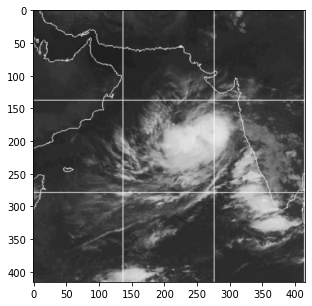

YOLO v3 took 2.47023 seconds
<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
image_input = cv2.imread("/content/drive/MyDrive/yolo_custom_model_training/testing_images/20010523.21-90.jpg")

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
#plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.savefig("Original1" + ".jpg", transparent = True, bbox_inches = 'tight')
plt.show()

blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB = True, crop = False)

# Check point
print(image_input.shape)
print(blob.shape)

blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v3 took {:.5f} seconds'.format(end - start))

print(type(output_from_network))
print(type(output_from_network[0]))

## Colors for representing every detected object

In [ ]:
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  # (80, 3)
print(colours[0])  # [102 220 225]

# Preparing lists for detected bounding boxes, obtained confidences and class number
bounding_boxes = []
confidences = []
class_numbers = []

# getting special dimesnion of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

print(h, w)

(1, 3)
[102 220 225]
339 334


## Going through all output layers after feed forward

In [ ]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

## Implementing non maximum suppression of given boxes and corresponding scores

In [ ]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

cyclone


## Drawing bounding boxes and labels

In [ ]:
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_PLAIN, 0.9, colour_box_current, 1)


        img2 = cv2.imread('Detected1.jpg')
        crop_img2 = img2[y_min:y_min + box_height, x_min:x_min + box_width]
        cv2.imwrite('Crop_detected1.jpg', crop_img2)

## Showing RGB image with bounding boxes and labels

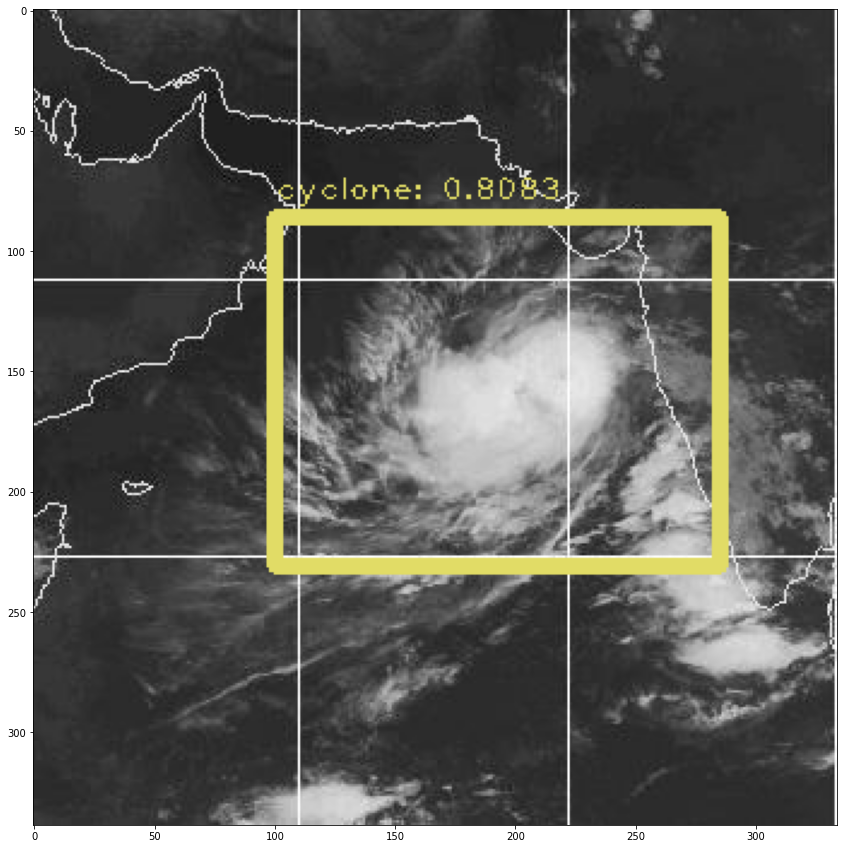

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.savefig("Detected1" + ".jpg", transparent = True, bbox_inches = 'tight')
plt.show()